In [1]:
import matplotlib.pyplot as plt
import numpy as np
import json

In [2]:
gpu_lists = ['1080', '3090']
batch_sizes = ['16', '32']
models = ['alexnet', 'resnet34']

trace_files = []
for gpu in gpu_lists:
    for batch in batch_sizes:
        for model in models:
            trace_files.append(f'{gpu}-batch-{batch}-{model}-trace.json')

for trace in trace_files:
    print(trace)

1080-batch-16-alexnet-trace.json
1080-batch-16-resnet34-trace.json
1080-batch-32-alexnet-trace.json
1080-batch-32-resnet34-trace.json
3090-batch-16-alexnet-trace.json
3090-batch-16-resnet34-trace.json
3090-batch-32-alexnet-trace.json
3090-batch-32-resnet34-trace.json


In [3]:
def load_data(trace_path):
    with open(trace_path) as json_file:
        json_data = json.load(json_file)

        for key in json_data.keys():
            pass
            # print(key)

        events = json_data['traceEvents']

        cuda_events = []
        wall_times = []
        timestamps = []

        for event in events:
            if 'stream' in str(event['tid']) and \
                    'name' in event.keys() and \
                    'dur' in event.keys() and \
                    event['cat'] == 'Kernel':
                cuda_events.append(event)
                # print(f"{event['ts']}: {event['dur']}")

                wall_times.append(event['dur'])
                timestamps.append(event['ts'])

        kernel_names = []
        kernel_sum_dur = {}
        kernel_count = {}
        for event in cuda_events:
            kernel_names.append(event['name'])
            kernel_sum_dur[event['name']] = 0
            kernel_count[event['name']] = 0

        kernel_names = np.unique(kernel_names)

        for i in range(len(kernel_names)):
            name = kernel_names[i]
            # print(f'{i}: {kernel_names[i]}')

        for event in cuda_events:
            kernel_sum_dur[event['name']] += event["dur"]
            kernel_count[event['name']] += 1

        for event in cuda_events:
            kernel_sum_dur[event['name']] /= kernel_count[event['name']]


        return {
            "wall_times": wall_times,
            "timestamps": timestamps,
            "kernel_names": kernel_names,
            "kernel_count": kernel_count,
            "kernel_info": kernel_sum_dur
        }

In [4]:
def draw_comparison(model_info, big_gpu_info, small_gpu_info):
    print(model_info["model-name"])
    print()

    trace_big = load_data(big_gpu_info["trace-path"])
    trace_small = load_data(small_gpu_info["trace-path"])

    kernel_info_big = trace_big["kernel_info"]
    kernel_info_big = dict(sorted(kernel_info_big.items(), key=lambda  item: item[1]))
    print(f'{big_gpu_info["gpu-name"]}')
    for key in kernel_info_big.keys():
        print(f'{trace_big["kernel_count"][key]}:{kernel_info_big[key]:10.5f}: {key}')

    print()

    kernel_info_small = trace_small["kernel_info"]
    kernel_info_small = dict(sorted(kernel_info_small.items(), key=lambda  item: item[1]))
    print(f'{small_gpu_info["gpu-name"]}')
    for key in kernel_info_small.keys():
        print(f'{trace_small["kernel_count"][key]}:{kernel_info_small[key]:10.5f}: {key}')

    durations_big = [trace_big["wall_times"][i] for i in range(len(trace_big["wall_times"]))]
    durations_small = [trace_small["wall_times"][i] for i in range(len(trace_small["wall_times"]))]

    plt.title(f"{model_info['model-name']} (batch: {model_info['batch-size']})")
    ax = plt.subplot(111)
    ax.set_xlabel("kernels in timeline")
    ax.set_ylabel("wall time (us)")
    if "kernel-idx-lim" in model_info.keys():
        lim = model_info["kernel-idx-lim"]
        ax.plot(np.arange(lim[1] - lim[0]), durations_small[lim[0]:lim[1]], '-', color='steelblue', label=small_gpu_info["gpu-name"])
        ax.plot(np.arange(lim[1] - lim[0]), durations_big[lim[0]:lim[1]], '-', color='darkorange',  label=big_gpu_info["gpu-name"])
    else:
        ax.plot(np.arange(len(trace_small["wall_times"])), durations_small, '-', color='steelblue', label=small_gpu_info["gpu-name"])
        ax.plot(np.arange(len(trace_big["wall_times"])), durations_big, '-', color='darkorange',  label=big_gpu_info["gpu-name"])
    ax.legend()
    plt.savefig(f"{model_info['model-name']}-batch-{model_info['batch-size']}.png", dpi=400)

AlexNet

RTX-3090
7:   0.00017: void at::native::vectorized_elementwise_kernel<4, at::native::(anonymous namespace)::clamp_min_scalar_kernel_impl(at::TensorIterator&, c10::Scalar)::{lambda()#1}::operator()() const::{lambda()#8}::operator()() const::{lambda(float)#1}, at::detail::Array<char*, 2> >(int, at::native::(anonymous namespace)::clamp_min_scalar_kernel_impl(at::TensorIterator&, c10::Scalar)::{lambda()#1}::operator()() const::{lambda()#8}::operator()() const::{lambda(float)#1}, at::detail::Array<char*, 2>)
5:   0.04640: void at::native::unrolled_elementwise_kernel<at::native::AddFunctor<float>, at::detail::Array<char*, 3>, OffsetCalculator<2, unsigned int>, OffsetCalculator<1, unsigned int>, at::native::memory::LoadWithoutCast, at::native::memory::StoreWithoutCast>(int, at::native::AddFunctor<float>, at::detail::Array<char*, 3>, OffsetCalculator<2, unsigned int>, OffsetCalculator<1, unsigned int>, at::native::memory::LoadWithoutCast, at::native::memory::StoreWithoutCast)
3:   0.2

<ipython-input-4-862cdc8cd452>:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(111)


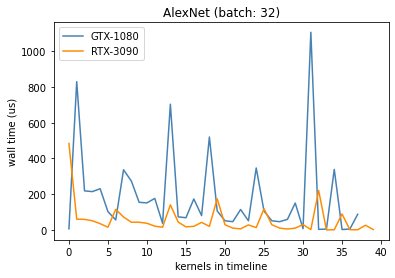

In [5]:
draw_comparison({"model-name": "AlexNet",
                 "batch-size": 32},
                {"trace-path": "./3090-batch-32-alexnet-trace.json",
                 "gpu-name": "RTX-3090"},
                {"trace-path": "./1080-batch-32-alexnet-trace.json",
                 "gpu-name": "GTX-1080",})

ResNet34

RTX-3090
36:   0.00000: void cudnn::bn_fw_inf_1C11_kernel_NCHW<float, float, true, 1>(float, float, cudnnTensorStruct, float const*, cudnnTensorStruct, float*, cudnnTensorStruct, float const*, float const*, float const*, float const*, float)
33:   0.00000: void at::native::vectorized_elementwise_kernel<4, at::native::(anonymous namespace)::clamp_min_scalar_kernel_impl(at::TensorIterator&, c10::Scalar)::{lambda()#1}::operator()() const::{lambda()#8}::operator()() const::{lambda(float)#1}, at::detail::Array<char*, 2> >(int, at::native::(anonymous namespace)::clamp_min_scalar_kernel_impl(at::TensorIterator&, c10::Scalar)::{lambda()#1}::operator()() const::{lambda()#8}::operator()() const::{lambda(float)#1}, at::detail::Array<char*, 2>)
23:   0.00000: void cudnn::winograd_nonfused::winogradForwardFilter4x4<float, float>(cudnn::winograd_nonfused::WinogradFilterParams<float, float>)
23:   0.00000: void cudnn::winograd_nonfused::winogradForwardData4x4<float, float>(cudnn::winograd_n

<ipython-input-4-862cdc8cd452>:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(111)


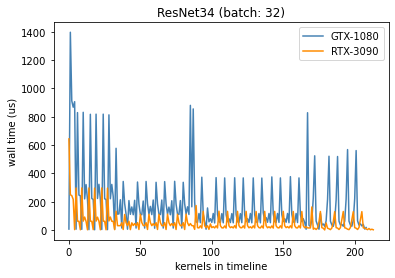

In [6]:
draw_comparison({"model-name": "ResNet34",
                 "batch-size": 32},
                {"trace-path": "./3090-batch-32-renset34-trace.json",
                 "gpu-name": "RTX-3090"},
                {"trace-path": "./1080-batch-32-renset34-trace.json",
                 "gpu-name": "GTX-1080",})

MobileNet-v2

RTX-3090
52:   0.00000: void cudnn::bn_fw_inf_1C11_kernel_NCHW<float, float, true, 1>(float, float, cudnnTensorStruct, float const*, cudnnTensorStruct, float*, cudnnTensorStruct, float const*, float const*, float const*, float const*, float)
35:   0.00000: void at::native::vectorized_elementwise_kernel<4, at::native::(anonymous namespace)::clamp_scalar_kernel_impl(at::TensorIterator&, c10::Scalar, c10::Scalar)::{lambda()#1}::operator()() const::{lambda()#8}::operator()() const::{lambda(float)#1}, at::detail::Array<char*, 2> >(int, at::native::(anonymous namespace)::clamp_scalar_kernel_impl(at::TensorIterator&, c10::Scalar, c10::Scalar)::{lambda()#1}::operator()() const::{lambda()#8}::operator()() const::{lambda(float)#1}, at::detail::Array<char*, 2>)
28:   0.00000: void nchwToNhwcKernel<float, float, float, true, false, (cudnnKernelDataType_t)2>(int, int, int, int, float const*, float*, float, float)
17:   0.00000: void spatialDepthwiseConvolutionUpdateOutput<float, float

<ipython-input-4-862cdc8cd452>:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(111)


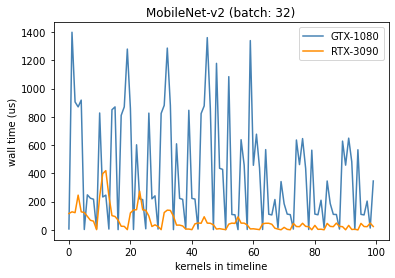

In [7]:
draw_comparison({"model-name": "MobileNet-v2",
                 "batch-size": 32,
                 "kernel-idx-lim": [0, 100]},
                {"trace-path": "./3090-batch-32-mobilenetv2-trace.json",
                 "gpu-name": "RTX-3090"},
                {"trace-path": "./1080-batch-32-mobilenetv2-trace.json",
                 "gpu-name": "GTX-1080",})

ResNet152

RTX-3090
155:   0.00000: void cudnn::bn_fw_inf_1C11_kernel_NCHW<float, float, true, 1>(float, float, cudnnTensorStruct, float const*, cudnnTensorStruct, float*, cudnnTensorStruct, float const*, float const*, float const*, float const*, float)
151:   0.00000: void at::native::vectorized_elementwise_kernel<4, at::native::(anonymous namespace)::clamp_min_scalar_kernel_impl(at::TensorIterator&, c10::Scalar)::{lambda()#1}::operator()() const::{lambda()#8}::operator()() const::{lambda(float)#1}, at::detail::Array<char*, 2> >(int, at::native::(anonymous namespace)::clamp_min_scalar_kernel_impl(at::TensorIterator&, c10::Scalar)::{lambda()#1}::operator()() const::{lambda()#8}::operator()() const::{lambda(float)#1}, at::detail::Array<char*, 2>)
188:   0.00000: void nchwToNhwcKernel<float, float, float, true, false, (cudnnKernelDataType_t)2>(int, int, int, int, float const*, float*, float, float)
51:   0.00000: void xmma_new::gemm::kernel<xmma_new::implicit_gemm::fprop::Kernel_traits<x

<ipython-input-4-862cdc8cd452>:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(111)


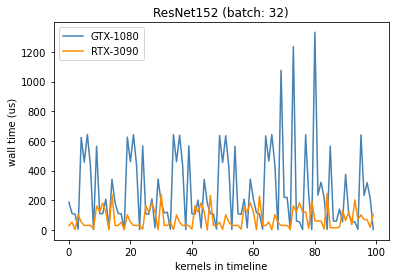

In [8]:
draw_comparison({"model-name": "ResNet152",
                 "batch-size": 32,
                 "kernel-idx-lim": [100, 200]},
                {"trace-path": "./3090-batch-32-resnet152-trace.json",
                 "gpu-name": "RTX-3090"},
                {"trace-path": "./1080-batch-32-resnet152-trace.json",
                 "gpu-name": "GTX-1080",})